In [1]:
import sys
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
sys.path.append("../../")

In [2]:
%load_ext autoreload
%autoreload 2

## Importing `solver` and tokens

In [3]:
from pydens import Solver, D, V, TorchModel, ConvBlockModel
from pydens import NumpySampler as NS

## Simple ODE

In [4]:
def ode(f, x):
    return D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)

In [6]:
solver = Solver(ode, ndims=1, initial_condition=.5, activation='Tanh')

In [7]:
solver.fit(niters=1500, batch_size=400)

100%|██████████| 1500/1500 [00:03<00:00, 471.17it/s]


In [8]:
xs = torch.tensor(np.linspace(0, 1, 100)).float()
approxs = solver.solve(xs)

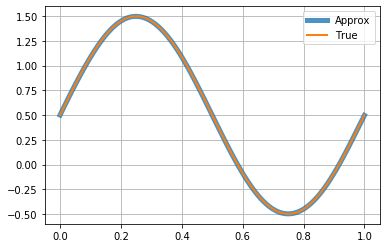

In [9]:
plt.plot(xs.detach().numpy(), approxs, label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()) + .5,
         label='True', linewidth=2)
plt.grid()
plt.legend()

## Simple PDE: Poisson

In [10]:
def pde(f, x, y):
    return D(D(f, x), x) + D(D(f, y), y) - 5 * torch.sin(np.pi * (x + y))

In [11]:
solver = Solver(pde, ndims=2, boundary_condition=1,
                model=ConvBlockModel,
                layout='fafaf', units=[10, 10, 1], activation='Tanh')

In [12]:
solver.fit(niters=500, batch_size=400, lr=0.05)

100%|██████████| 500/500 [00:02<00:00, 180.28it/s]


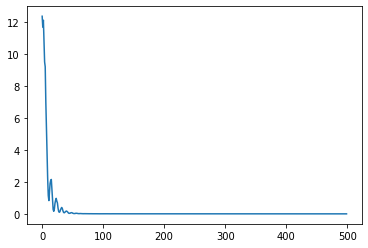

In [12]:
plt.plot(solver.losses[:])

In [26]:
def cart_prod(*arrs):
    """ Get array of cartesian tuples from arbitrary number of arrays.
    """
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

In [14]:
grid = cart_prod(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

In [15]:
approxs = solver.solve(torch.tensor(grid[:, 0:1]).float(),
                       torch.tensor(grid[:, 1:2]).float())

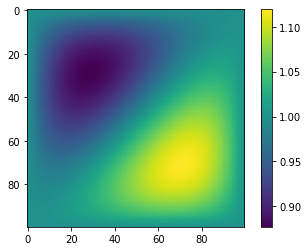

In [16]:
plt.imshow(approxs.reshape((100, 100)))
plt.colorbar()

## Parametric family of ODEs

In [14]:
def odeparam(f, x, e):
    return D(f, x) - e * np.pi * torch.cos(e * np.pi * x)

In [15]:
solver = Solver(odeparam, ndims=1, initial_condition=2.0, nparams=1)

In [16]:
sampler = NS('u') & NS('u', low=.5, high=5.5)

In [17]:
solver.fit(niters=10000, batch_size=700, sampler=sampler)

100%|██████████| 10000/10000 [00:25<00:00, 392.13it/s]


In [18]:
# checking out the solution approximation for fixed epsilon
eps = 3.5
approxs = solver.solve(xs, torch.ones_like(xs) * eps)
true = np.sin(eps * np.pi * xs.numpy()) + 2

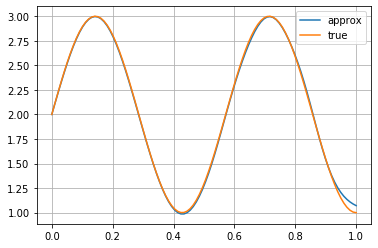

In [19]:
plt.plot(xs.detach().numpy(), approxs, label='approx')
plt.plot(xs.detach().numpy(), true, label='true')
plt.grid()
plt.legend()

## Heat equation in 2D (metal plate)

In [20]:
def pde(f, x, y, t, a):
    return D(D(f, x), x) + D(D(f, y), y) - a * D(f, t)

In [21]:
solver = Solver(pde, ndims=3, nparams=1,
                initial_condition=lambda x, y: 10 * x * y * (1 - x) * (1 - y),
                boundary_condition=0, layout='fafaf', units=[30, 40, 1], activation='Sigmoid')

In [22]:
sampler = NS('u', dim=2) & NS('u', low=0, high=.5) &  NS('u', low=.1, high=4)

In [23]:
solver.fit(niters=5000, batch_size=1500, lr=0.05)

100%|██████████| 5000/5000 [01:57<00:00, 42.41it/s]


In [24]:
def get_approxs(t=.1, param=1.):
    grid = cart_prod(np.linspace(0, 1, 100),
                     np.linspace(0, 1, 100))

    xs, ys = torch.tensor(grid[:, 0:1]).float(), torch.tensor(grid[:, 1:2]).float()
    ts = torch.full_like(xs, t)
    ps = torch.full_like(xs, param)

    return solver.solve(xs, ys, ts, ps).reshape((100, 100))

* gather means

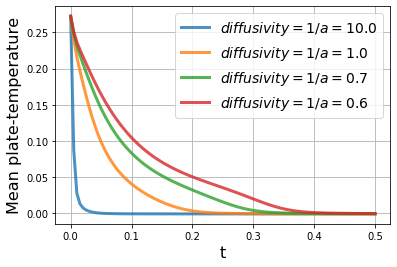

In [28]:
xs = np.linspace(0, .5, 100)
for p in [.1, 1, 1.5, 1.8]:
    plt.plot(xs, [np.mean(get_approxs(t=t, param=p)) for t in xs],
             label=fr'$diffusivity= 1 / a = {1 / p:3.1f}$', linewidth=3, alpha=0.8)
plt.legend(fontsize=14)
plt.xlabel(r't', fontsize=16)
plt.ylabel('Mean plate-temperature', fontsize=16)
plt.grid()

## ODE with trainable coefficients

In [29]:
def odevar(f, x):
    return (D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)
            + V('new_var', data=torch.Tensor([1.0])))

In [30]:
solver = Solver(odevar, ndims=1, initial_condition=1,
                constraints=lambda f, x: f(torch.tensor([0.5])))

In [31]:
solver.model.freeze_trainable(variables=('new_var',))

In [32]:
solver.fit(niters=150, batch_size=500, lr=0.05)

100%|██████████| 150/150 [00:00<00:00, 474.11it/s]


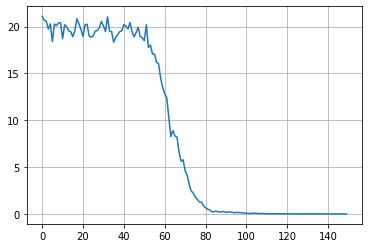

In [33]:
plt.plot(solver.losses[:])
plt.grid()

In [34]:
xs = torch.Tensor(np.linspace(0, 1, 100))
approxs = solver.solve(xs)

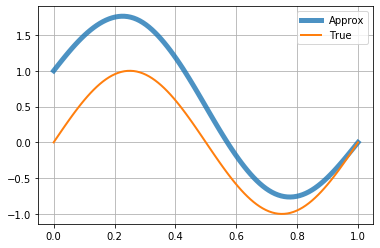

In [35]:
plt.plot(xs.detach().numpy(), approxs, label='Approx', linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()),
         label='True', linewidth=2)
plt.grid()
plt.legend()

In [37]:
solver.model.unfreeze_trainable(variables=['new_var'])

In [38]:
solver.fit(niters=100, batch_size=100, lr=0.1,
           losses=['equation', 'constraint_0'])

  0%|          | 0/100 [00:00<?, ?it/s]/Users/aleksandr/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:00<00:00, 424.67it/s]


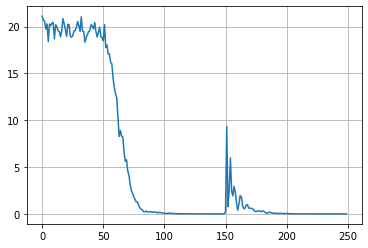

In [39]:
plt.plot(solver.losses[:])
plt.grid()

In [40]:
approxs = solver.solve(xs)

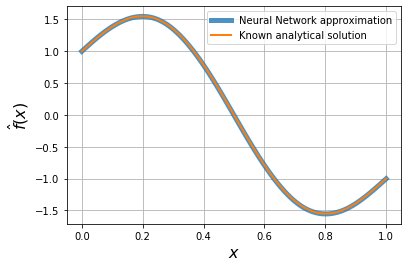

In [41]:
xs_ = xs.detach().numpy()
plt.plot(xs_, approxs, label='Neural Network approximation',
         linewidth=5, alpha=0.8)
plt.plot(xs_, np.sin(2 * np.pi * xs_) + 1 - 2 * xs_,
         label='Known analytical solution', linewidth=2)
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$\hat{f}(x)$', fontsize=16)
plt.grid()
plt.legend()